# Task 4：玩家流失的预测建模

构建一个机器学习模型来预测玩家在下一个月内停止玩游戏的可能性。


### Part 1 - Data Loading
读取csv获取数据

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 忽略警告
warnings.filterwarnings("ignore")

# 读取数据
df = pd.read_csv('game_events.csv')
df.head()


,EventID,PlayerID,EventTimestamp,EventType,EventDetails,DeviceType,Location
0,E10000000,P1000000,2023-01-01,SessionStart,-,Android,USA
1,E10000001,P1000000,2023-01-01,InAppPurchase,Amount: 11.09,Android,USA
2,E10000002,P1000001,2023-01-01,SessionStart,-,iOS,Singapore
3,E10000003,P1000001,2023-01-01,InAppPurchase,Amount: 49.29,iOS,Singapore
4,E10000004,P1000002,2023-01-01,SessionStart,-,Android,Singapore


## Part 2: Feature Engineering & Data Preprocessing
Preprocess the dataset and create meaningful features to fit machine learning models 

In [6]:
# 获取每个玩家的总event数
df['times'] = df.groupby(by='PlayerID')['PlayerID'].transform('count')

df.head()

,EventID,PlayerID,EventTimestamp,EventType,EventDetails,DeviceType,Location,times
0,E10000000,P1000000,2023-01-01,SessionStart,-,Android,USA,13
1,E10000001,P1000000,2023-01-01,InAppPurchase,Amount: 11.09,Android,USA,13
2,E10000002,P1000001,2023-01-01,SessionStart,-,iOS,Singapore,13
3,E10000003,P1000001,2023-01-01,InAppPurchase,Amount: 49.29,iOS,Singapore,13
4,E10000004,P1000002,2023-01-01,SessionStart,-,Android,Singapore,14


In [7]:
# 提取事件的日期部分
df['EventTimestamp'] = df['EventTimestamp'].str.slice(0, 10)

# 转换为datetime类型
df['EventTimestamp'] = pd.to_datetime(df['EventTimestamp'])

df.head()

,EventID,PlayerID,EventTimestamp,EventType,EventDetails,DeviceType,Location,times
0,E10000000,P1000000,2023-01-01,SessionStart,-,Android,USA,13
1,E10000001,P1000000,2023-01-01,InAppPurchase,Amount: 11.09,Android,USA,13
2,E10000002,P1000001,2023-01-01,SessionStart,-,iOS,Singapore,13
3,E10000003,P1000001,2023-01-01,InAppPurchase,Amount: 49.29,iOS,Singapore,13
4,E10000004,P1000002,2023-01-01,SessionStart,-,Android,Singapore,14


In [8]:
# 计算每个玩家每个月的事件次数
df['current_month'] = pd.to_datetime(df['EventTimestamp']).dt.to_period('M').dt.to_timestamp()
df['month_times'] = df.groupby(by=['PlayerID', 'current_month'])['PlayerID'].transform('count')

df.head()

,EventID,PlayerID,EventTimestamp,EventType,EventDetails,DeviceType,Location,times,current_month,month_times
0,E10000000,P1000000,2023-01-01,SessionStart,-,Android,USA,13,2023-01-01,3
1,E10000001,P1000000,2023-01-01,InAppPurchase,Amount: 11.09,Android,USA,13,2023-01-01,3
2,E10000002,P1000001,2023-01-01,SessionStart,-,iOS,Singapore,13,2023-01-01,5
3,E10000003,P1000001,2023-01-01,InAppPurchase,Amount: 49.29,iOS,Singapore,13,2023-01-01,5
4,E10000004,P1000002,2023-01-01,SessionStart,-,Android,Singapore,14,2023-01-01,4


In [9]:
# 计算下个月的日期
df['next_month'] = pd.to_datetime(df['EventTimestamp'] + pd.DateOffset(months=1)).dt.to_period('M').dt.to_timestamp()

df.head()

,EventID,PlayerID,EventTimestamp,EventType,EventDetails,DeviceType,Location,times,current_month,month_times,next_month
0,E10000000,P1000000,2023-01-01,SessionStart,-,Android,USA,13,2023-01-01,3,2023-02-01
1,E10000001,P1000000,2023-01-01,InAppPurchase,Amount: 11.09,Android,USA,13,2023-01-01,3,2023-02-01
2,E10000002,P1000001,2023-01-01,SessionStart,-,iOS,Singapore,13,2023-01-01,5,2023-02-01
3,E10000003,P1000001,2023-01-01,InAppPurchase,Amount: 49.29,iOS,Singapore,13,2023-01-01,5,2023-02-01
4,E10000004,P1000002,2023-01-01,SessionStart,-,Android,Singapore,14,2023-01-01,4,2023-02-01


In [10]:
# 创建包含下个月、当前月和PlayerID的唯一数据框
unique_df = df[['next_month', 'PlayerID', 'current_month']].drop_duplicates()

# 使用 merge 合并唯一数据框，计算玩家是否在下个月仍然活跃
gameplay_df = pd.merge(left=unique_df, right=unique_df, left_on=['next_month', 'PlayerID'], right_on=['current_month', 'PlayerID'])
gameplay_df['lost'] = 0

gameplay_df.head()

,next_month_x,PlayerID,current_month_x,next_month_y,current_month_y,lost
0,2023-02-01,P1000008,2023-01-01,2023-03-01,2023-02-01,0
1,2023-02-01,P1000013,2023-01-01,2023-03-01,2023-02-01,0
2,2023-02-01,P1000016,2023-01-01,2023-03-01,2023-02-01,0
3,2023-02-01,P1000017,2023-01-01,2023-03-01,2023-02-01,0
4,2023-02-01,P1000035,2023-01-01,2023-03-01,2023-02-01,0


In [11]:
 #使用 merge 合并原始数据框，添加 'lost' column
df = pd.merge(left=df, right=gameplay_df, left_on=['current_month', 'PlayerID'], right_on=['current_month_x', 'PlayerID'], how='left')

# fill in missing data with '1'
df['lost'] = df['lost'].fillna(1)

# clean out unneccessary columns
df.drop(columns=['next_month_x', 'current_month_x', 'next_month_y', 'current_month_y'], inplace=True)
df.head()

,EventID,PlayerID,EventTimestamp,EventType,EventDetails,DeviceType,Location,times,current_month,month_times,next_month,lost
0,E10000000,P1000000,2023-01-01,SessionStart,-,Android,USA,13,2023-01-01,3,2023-02-01,1.0
1,E10000001,P1000000,2023-01-01,InAppPurchase,Amount: 11.09,Android,USA,13,2023-01-01,3,2023-02-01,1.0
2,E10000002,P1000001,2023-01-01,SessionStart,-,iOS,Singapore,13,2023-01-01,5,2023-02-01,1.0
3,E10000003,P1000001,2023-01-01,InAppPurchase,Amount: 49.29,iOS,Singapore,13,2023-01-01,5,2023-02-01,1.0
4,E10000004,P1000002,2023-01-01,SessionStart,-,Android,Singapore,14,2023-01-01,4,2023-02-01,1.0


In [12]:
# 数据预处理，去除重复行
data = df[['DeviceType', 'times', 'month_times', 'lost', 'current_month']].drop_duplicates()

# 特征和标签
X = data[['DeviceType', 'times', 'month_times']]
y = data['lost']
data.head()

,DeviceType,times,month_times,lost,current_month
0,Android,13,3,1.0,2023-01-01
2,iOS,13,5,1.0,2023-01-01
4,Android,14,4,1.0,2023-01-01
6,Android,16,8,1.0,2023-01-01
8,Android,11,3,1.0,2023-01-01


In [13]:
# one-hot Encoding
X = pd.get_dummies(X)

# split 80% traning and 20% testing 数据
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Part 3: Model Training and Result Evaluation

In [14]:
# 构建random forest模型
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 拟合模型
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [15]:
# prediction
y_pred = rf_model.predict(X_test)

# model evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.23      0.17      0.19       548
         1.0       0.50      0.60      0.55       774

    accuracy                           0.42      1322
   macro avg       0.37      0.38      0.37      1322
weighted avg       0.39      0.42      0.40      1322



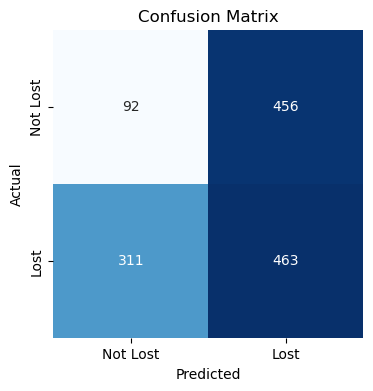

In [16]:
# 混淆矩阵可视化
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Lost', 'Lost'],
            yticklabels=['Not Lost', 'Lost'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()